In this notebook I want to classify the cells in their phase according to the PCNA patterns.

In [1]:
import pandas as pd
import numpy as np
from ccc_nn_functions import str2array

csv_file = r'C:\Users\rz200\Documents\development\cell-SCT\classification\imported_CSV\dataframe_822'
df = pd.read_csv(csv_file)

In [2]:
def df_ignore_rows(df):
    indices_to_skip_img_wrong_shape = [i for i in range(len(df)) if str2array(df['pcna_crops'][i]).dtype is np.dtype('object')]  # skipping rows with shapes such as (7,)
    indices_to_skip_no_class = df[(df['G1_Phase'] == False) & (df['S_Phase'] == False) & (df['G2_M_Phase'] == False)].index
    rows_to_ignore = np.concatenate((indices_to_skip_img_wrong_shape, indices_to_skip_no_class), axis=0)
    df = df.drop(set(rows_to_ignore)).reset_index(drop=True) #dropping the rows to ignore
    return df

df = df_ignore_rows(df)

C:\Users\rz200\Documents\development\cell-SCT\classification\ccc_nn_functions.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(ast.literal_eval(s))


In [3]:
def get_cell_labels(df):
    g1_indices = df[(df['G1_Phase'] == True)].index
    s_indices = df[(df['S_Phase'] == True)].index
    g2_m_indices = df[(df['G2_M_Phase'] == True)].index

    #make an array that is the length of all of these indices put into one, that is made of 0s
    #replace the 0s accordingly by which phase index they correspond to

    cell_labels = np.arange(len(g1_indices)+len(s_indices)+len(g2_m_indices))

    np.put(cell_labels,g1_indices,np.zeros(len(g1_indices)))
    np.put(cell_labels,s_indices,np.ones(len(s_indices)))
    np.put(cell_labels,g2_m_indices,np.full(len(g2_m_indices),2))

    return cell_labels

cell_labels = get_cell_labels(df)

In [4]:
pcna_crops = []
for i in range(len(df)): pcna_crops.append(str2array(df['pcna_crops'][i]))

In [5]:
import matplotlib.pyplot as plt
imgs_0 = []
imgs_1 = []
imgs_2 = []
for i in range(len(pcna_crops)):
    if cell_labels[i] == 0:
        imgs_0.append(pcna_crops[i])
    elif cell_labels[i] ==1:
        imgs_1.append(pcna_crops[i])
    elif cell_labels[i] ==2:
        imgs_2.append(pcna_crops[i])

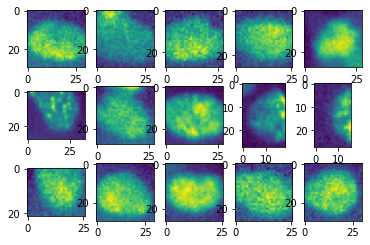

In [6]:
for i in range(15):
    if i < 5:
        image = imgs_0[i]*255
        thresholded = (image > 0) * image
        plt.subplot(3,5,i+1)
        plt.imshow(thresholded)
    elif i < 10:
        image = imgs_1[i]*255
        thresholded = (image > 0) * image
        plt.subplot(3,5,i+1)
        plt.imshow(thresholded)
    elif i < 15:
        image = imgs_2[i]*255
        thresholded = (image > 0) * image
        plt.subplot(3,5,i+1)
        plt.imshow(thresholded)

In [7]:
import mahotas as mt

def extract_features(image):
    # calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(image)

    # take the mean of it and return it
    ht_mean  = textures.mean(axis=0)
    return ht_mean

In [25]:
image = imgs_0[0]*255
#print(image.astype(np.int32))

print(type(extract_features(image.astype(np.int32))))

<class 'numpy.ndarray'>


In [31]:
haralick_features = []
for i in range(len(pcna_crops)):
    if i % 10000==0: print(str(i+1) + '/' + str(len(pcna_crops)))
    img = pcna_crops[i]*255
    img = img.astype(np.int32)
    haralick_features.append(extract_features(img))
haralick_features = np.array(haralick_features)

1/79386
10001/79386
20001/79386
30001/79386
40001/79386
50001/79386
60001/79386
70001/79386


In [34]:
print(len(haralick_features))
print(len(cell_labels))

79386
79386


In [35]:
print(haralick_features.shape)

(79386, 13)


In [36]:
print(haralick_features[0])

[ 2.27754781e-02  1.66274277e+00  9.16926255e-01  1.00131108e+01
  5.86601510e-01  5.18328181e+01  3.83897005e+01  4.41374278e+00
  5.77297947e+00  9.49311472e-03  1.72204874e+00 -3.65490692e-01
  9.60716698e-01]


In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

images = haralick_features
values = cell_labels

X_train, X_test, y_train, y_test = train_test_split(images, values, test_size=0.4, random_state=42)
reg = LinearRegression().fit(X_train,y_train)
predictions = np.round(reg.predict(X_test)).astype(int) #rounding the values to 0 or 1
correct = np.count_nonzero(y_test == predictions)
print('Accuracy:',correct*100/len(X_test))

Accuracy: 44.767753109746494


In [12]:
image = imgs_0[0]*255
print(image.astype(np.int32))

[[22 21 21 22 21 23 22 22 21 22 23 22 22 21 21 22 21 21 22 21 21 21 21 22
  20 20 20 19 20 20]
 [22 22 21 21 21 22 23 23 21 22 22 22 22 22 22 20 21 21 21 22 21 21 22 21
  20 22 22 21 21 20]
 [22 22 21 22 22 21 21 21 21 20 21 20 22 21 22 22 21 22 22 20 21 21 20 22
  21 21 20 21 20 20]
 [22 22 21 22 22 22 22 21 22 22 21 22 22 21 23 22 21 21 21 21 20 21 21 21
  22 21 22 20 20 21]
 [21 23 22 21 21 21 21 22 21 22 21 23 21 23 22 22 22 22 21 21 20 21 22 20
  21 20 22 20 20 21]
 [22 22 22 22 22 22 22 22 23 22 24 24 23 22 23 22 22 22 23 22 21 21 20 22
  21 20 21 21 20 20]
 [22 21 21 23 23 23 24 24 25 25 25 26 25 26 25 26 24 24 23 23 22 22 23 22
  21 22 22 21 21 20]
 [22 23 21 22 23 23 24 24 25 27 27 26 26 27 25 24 24 24 24 24 24 23 23 23
  22 21 21 21 22 21]
 [23 22 22 24 24 25 25 27 28 28 27 28 28 27 25 26 25 24 25 26 25 25 25 25
  23 23 23 21 20 21]
 [23 23 23 24 26 27 27 27 27 27 29 26 27 27 26 26 26 26 27 28 26 27 26 25
  25 25 24 23 21 22]
 [22 23 24 25 26 26 28 28 29 28 28 28 27 27 26 27 

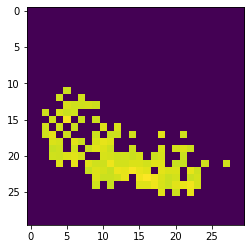

In [151]:
from skimage.filters import threshold_otsu

image = imgs_0[0]*255

thresholded = (image > 30) * image
plt.imshow(thresholded)

In [ ]:
for i in range(10):
    plt.imshow()

<class 'numpy.ndarray'>


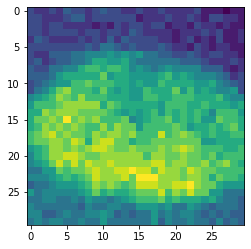

In [61]:
from PIL import Image

img = imgs_0[0]*255
print(type(img))
img = img.astype(np.uint8)

pil_img = Image.fromarray(img)
plt.imshow(pil_img)

In [64]:
pix = np.array(pil_img)
print(pix.shape)

(30, 30)


ValueError: negative dimensions are not allowed

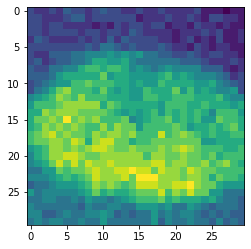

In [66]:
from skimage.feature import hog
image = imgs_0[0]*255
image = image.astype(np.uint8)
image = np.expand_dims(image,axis=-1)
plt.imshow(image)
#print(image)
#print(image.reshape(30,30,1))
pix = np.expand_dims(pix,axis=-1)
fd,hog_image = hog(pix, orientations=8, pixels_per_cell=(16,16),cells_per_block=(4, 4),channel_axis=0)

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import matplotlib.pyplot as plt
import time
import copy
import os

In [68]:
batch_size = 128
learning_rate = 1e-3

transforms = transforms.Compose(
    [
        transforms.ToTensor()
    ])

In [112]:
class CellDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, pcna_crops, cell_labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pcna_crops = pcna_crops
        self.cell_labels = cell_labels
        self.transform = transform

    def __len__(self):
        return len(self.cell_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = pcna_crops[idx]
        label = cell_labels[idx]

        img = torch.from_numpy(img)
        label = torch.tensor(label)

        img = T.CenterCrop(32)(img)
        #img = transform(img)



        sample = {'image': img, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [113]:
train_pcna_crops = pcna_crops[0:70000]
train_cell_labels = cell_labels[0:70000]

test_pcna_crops = pcna_crops[70000:len(pcna_crops)]
test_cell_labels = cell_labels[70000:len(pcna_crops)]

print(len(train_pcna_crops),len(test_pcna_crops))

70000 9386


In [114]:
train_dataloader = DataLoader(CellDataset(train_pcna_crops,train_cell_labels), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(CellDataset(test_pcna_crops,test_cell_labels), batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [115]:
net = models.resnet18(pretrained=True)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [116]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() #if use_cuda else net.fc

In [124]:
#Lots of zeros in the image tensore, should it be multplied by 255 before classifying?
for batch_idx, sample in enumerate(train_dataloader):
    print(sample['image'])
    break

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1063,  ..., 0.1070, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.1070,  ..., 0.1133, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1798,  ..., 0.1775, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.2117,  ..., 0.2032, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [122]:
ddd = train_dataloader[0]
print(ddd['image'])

TypeError: 'DataLoader' object is not subscriptable

In [126]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, sample in enumerate(train_dataloader):
        data_ = sample['image']
        target_ = sample['label']

        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()

        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')


        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1



RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 128, 32, 32] to have 3 channels, but got 128 channels instead